In this notebook the list of distance matrices to fed into the consensus clustering algorithm are computed. In order to not cluster based on age, sex and center, we harmonise the data using pycombat, removing site, age and sex effects

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from os.path import join as opj
from scipy.io import savemat, loadmat
import os
import pickle
from scipy.stats import pearsonr, ttest_ind, kruskal, levene
from scipy.spatial.distance import squareform, pdist
from statsmodels.stats.multitest import multipletests

In [2]:
# Data directory
data_dir = "/path/to/data/folder"

In [3]:
# Read ASD subjects
f = open(opj(data_dir, "subjects_subgroups_My21_FD03.pkl"), "rb")
subjects_subgroups = pickle.load(f, encoding='utf-8')
f.close()

asd_subjects = subjects_subgroups['asd_subjs']
td_subjects = subjects_subgroups['tc_subjs']
subjects = np.concatenate((td_subjects, asd_subjects)) #Concatenate subjects to have first TDC and then ASD

# Load demo data
demo = pd.read_excel(opj(data_dir, "demo_final_82regs_My2021_FD03.xlsx"))

# Compute non interest sources of variability
# Beware, first subjects on the merge to preserve this order
print(np.allclose(subjects, pd.merge(pd.DataFrame({'SUB_ID': subjects}), demo).SUB_ID))

# Extract different variables (age, sex, site id, group, motion and code ID)
age= pd.merge(pd.DataFrame({'SUB_ID': subjects}), demo).AGE_AT_SCAN.values
sex = pd.merge(pd.DataFrame({'SUB_ID':subjects}), demo ).SEX.values
site = pd.merge(pd.DataFrame({'SUB_ID':subjects}), demo).SITE_ID_MERGED
group = pd.merge(pd.DataFrame({'SUB_ID':subjects}), demo).DX_GROUP
motion = pd.merge(pd.DataFrame({'SUB_ID':subjects}), demo).loc[:, ["FD_mean", "DVARS_mean"]].to_numpy()
code_id = pd.merge(pd.DataFrame({'SUB_ID':subjects}), demo).loc[:, "Code"].to_list()

# Use code ID to extract time series filenames
ts_filenames = ["ts_" + name + ".txt" for name in code_id]

# Compute dummies for sex and group
sex_dummies = pd.get_dummies(sex, drop_first=True).values
group_dummies = pd.get_dummies(group, drop_first=True).values

# X=Effects of Interest, C=Covariates
C = np.column_stack((sex_dummies, age, motion)) # Covariate effects

X = (group_dummies==0).astype(int).reshape(-1,1) # effects of interest, i.e. group varialbe

# Read TS of these subjects and compute correlation matrix
list_corrs = []
for filename in tqdm.tqdm(ts_filenames):
    C_mat = np.corrcoef(np.loadtxt(opj(data_dir, "ASD_ts_desikan82_may21" , filename)).T) # the original way, omiting the first point
    list_corrs.append(C_mat)
# Take upper triangular elements only
Y_cor = np.row_stack([squareform(mat, checks=False) for mat in list_corrs])
# Convert to Z-fisher
Y = np.arctanh(Y_cor)

# Some constants
n_asd = len(asd_subjects) # Number of ASD subjects
n_td = len(td_subjects)  # Number of TDC subjects
n_rois = C_mat.shape[1]  # Number of Rois
n_links = Y.shape[1] # Number of connectivity entries

print("ASD subjects: {}, TD subjects: {}, Number of rois: {}, Number of links: {}".format(n_asd, 
                                                                                          n_td, 
                                                                                          n_rois, n_links))

True


100%|██████████████████████████████████████| 1541/1541 [00:11<00:00, 139.24it/s]


ASD subjects: 657, TD subjects: 884, Number of rois: 82, Number of links: 3321


### 1-Harmonise data, keeping group differences

In [4]:
from pycombat import Combat
from sklearn.preprocessing import LabelEncoder

# Convert site labels to integers
le =  LabelEncoder()
b =le.fit_transform(site.values)

combat = Combat()
# Run combat, preserving  group (ASD/TDC) differences
Y_combat = combat.fit_transform(Y, b=b, X=X, C=None)

let's see how well harmonisation worked

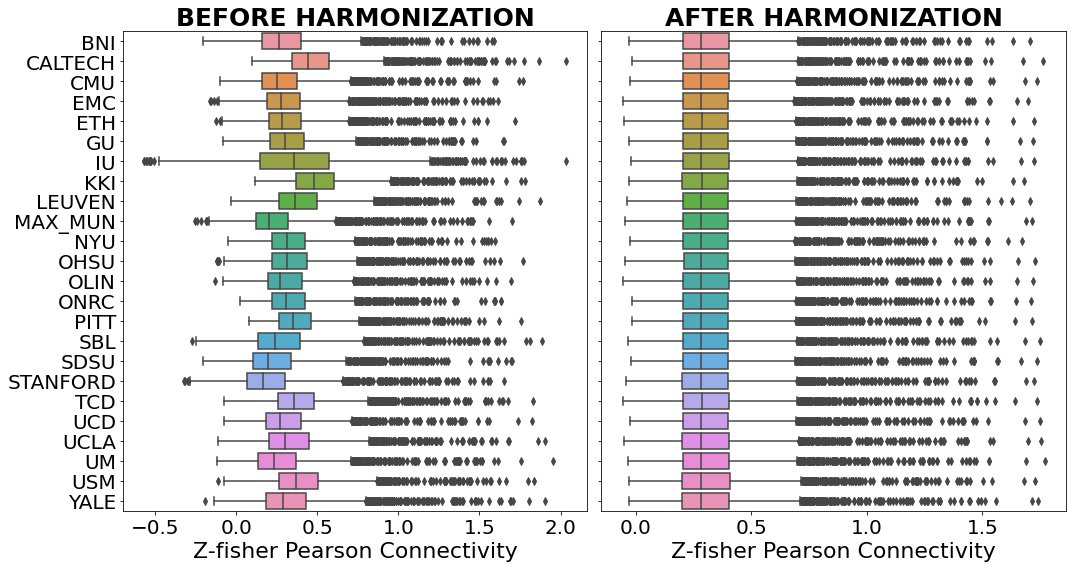

In [5]:
fig, axs = plt.subplots(figsize=(15, 8), ncols=2, sharey=True)

sns.boxplot(data=[Y[(site==name).values,:].mean(axis=0).T for name in site.unique()], 
            ax=axs[0], showfliers=True, orient='horizontal')
axs[0].set_yticklabels(le.classes_, rotation=0, size=20)
#axs[0].set_ylim([-2, 2])
axs[0].set_xlabel("Z-fisher Pearson Connectivity", size=22)
axs[0].set_ylabel("")
axs[0].set_title("BEFORE HARMONIZATION", size=25, weight='bold')
axs[0].tick_params(labelsize=20)
Y_df_combat = pd.DataFrame(Y_combat)
Y_df_combat['site'] = b
sns.boxplot(data=[Y_combat[(site==name).values,:].mean(axis=0).T for name in site.unique()], 
            showfliers=True, orient='horizontal')
axs[1].set_yticklabels(le.classes_, rotation=0)
axs[1].set_xlabel("Z-fisher Pearson Connectivity", size=22)
axs[1].set_title("AFTER HARMONIZATION", size=25, weight='bold')
axs[1].tick_params(labelsize=20)
plt.tight_layout()
pass

Test locations, using a kruskal-wallis test

In [6]:
location_before = np.array([kruskal(*[Y[np.where(b==ii)[0], jj] for ii in np.unique(b)]) for jj in tqdm.tqdm(range(n_links))])
location_after = np.array([kruskal(*[Y_combat[np.where(b==ii)[0], jj] for ii in np.unique(b)]) for jj in tqdm.tqdm(range(n_links))])

100%|█████████████████████████████████████| 3321/3321 [00:03<00:00, 1079.70it/s]


In [7]:
print("the number of links associated with center location before combat = %d" % sum(multipletests(location_before[:,1], method="fdr_bh")[0]))
print("the number of links associated with center location after combat = %d" % sum(multipletests(location_after[:,1], method="fdr_bh")[0]))

the number of links associated with center location before combat = 3321
the number of links associated with center location after combat = 0


/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


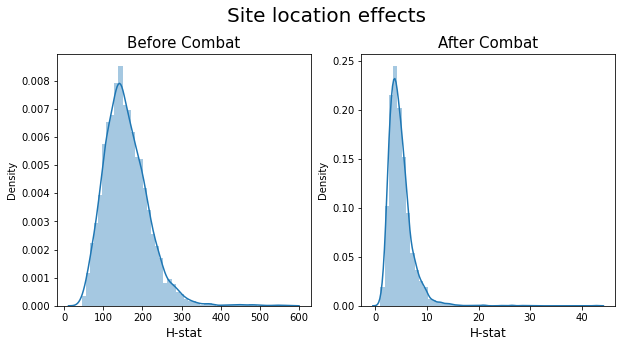

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.distplot(location_before[:,0], ax = axs[0])
axs[0].set_title("Before Combat", size=15)
axs[0].set_xlabel("H-stat", size=12)

sns.distplot(location_after[:,0], ax = axs[1])
axs[1].set_title("After Combat", size=15)
axs[1].set_xlabel("H-stat", size=12)
plt.suptitle("Site location effects", size=20)
fig.subplots_adjust(top=0.85, bottom=0.15)
pass

Test variances (batch scales), using a levene test.

In [9]:
scale_before = np.array([levene(*[Y[np.where(b==ii)[0], jj] for ii in np.unique(b)]) for jj in tqdm.tqdm(range(n_links))])
scale_after = np.array([levene(*[Y_combat[np.where(b==ii)[0], jj] for ii in np.unique(b)]) for jj in tqdm.tqdm(range(n_links))])

100%|██████████████████████████████████████| 3321/3321 [00:04<00:00, 761.26it/s]


In [10]:
print("the number of links associated with center scale before combat = %d"% sum(multipletests(scale_before[:,1], method="fdr_bh")[0]))
print("the number of links associated with center scale after combat = %d"% sum(multipletests(scale_after[:,1], method="fdr_bh")[0]))

the number of links associated with center scale before combat = 1236
the number of links associated with center scale after combat = 0


/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


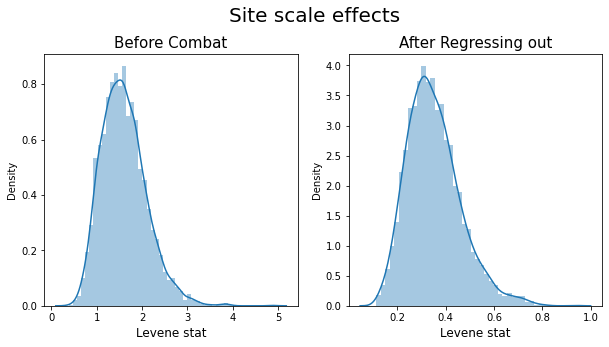

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.distplot(scale_before[:,0], ax = axs[0])
axs[0].set_title("Before Combat", size=15)
axs[0].set_xlabel("Levene stat", size=12)

sns.distplot(scale_after[:,0], ax = axs[1])
axs[1].set_title("After Regressing out", size=15)
axs[1].set_xlabel("Levene stat", size=12)
plt.suptitle("Site scale effects", size=20)
fig.subplots_adjust(top=0.85, bottom=0.15)
pass

### 2-Remove age, sex and motion (FD and DVARS) effects from ASD FC matrices using a linear regression

These denoised matrices will be saved and user later for subtyping

In [12]:
from sklearn.linear_model import LinearRegression

del Y # This is to guarantee that I am not taking the original data

# Take only ASD subjects
Y_asd_combat = Y_combat[np.squeeze(X)==1,:]
print(Y_asd_combat.shape)

linReg = LinearRegression()
linReg.fit(C[np.squeeze(X)==1], Y_asd_combat)
Y_asd_combat_denoised = Y_asd_combat - C[np.squeeze(X)==1,:].dot(linReg.coef_.T)

(657, 3321)


Let's see how denoising worked

/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


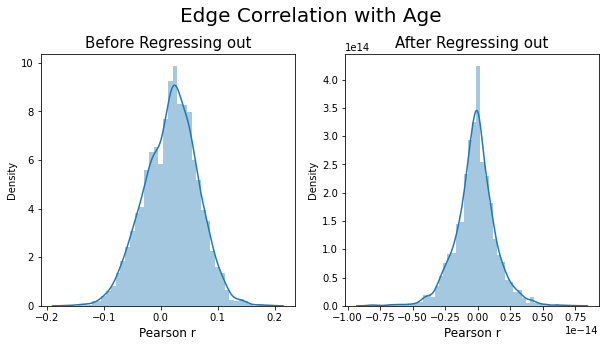

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.distplot([np.corrcoef(Y_asd_combat[:,ii], age[np.squeeze(X)==1])[0,1] \
              for ii in range(n_links)], ax = axs[0])
axs[0].set_title("Before Regressing out", size=15)
axs[0].set_xlabel("Pearson r", size=12)

sns.distplot([np.corrcoef(Y_asd_combat_denoised[:,ii], age[np.squeeze(X)==1])[0,1] \
              for ii in range(n_links)], ax = axs[1])
axs[1].set_title("After Regressing out", size=15)
axs[1].set_xlabel("Pearson r", size=12)
plt.suptitle("Edge Correlation with Age", size=20)
fig.subplots_adjust(top=0.85, bottom=0.15)
pass

/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


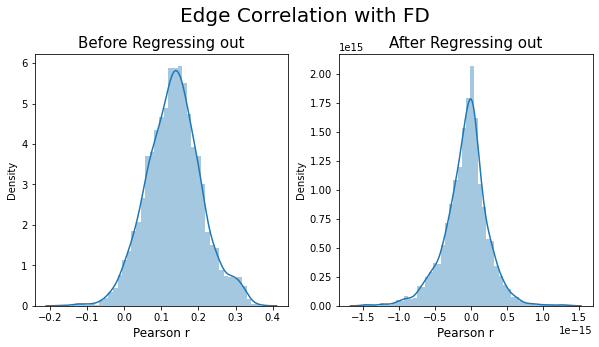

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.distplot([np.corrcoef(Y_asd_combat[:,ii], motion[np.squeeze(X)==1, 0])[0,1] \
              for ii in range(n_links)], ax = axs[0])
axs[0].set_title("Before Regressing out", size=15)
axs[0].set_xlabel("Pearson r", size=12)

sns.distplot([np.corrcoef(Y_asd_combat_denoised[:,ii], motion[np.squeeze(X)==1,0])[0,1] \
              for ii in range(n_links)], ax = axs[1])
axs[1].set_title("After Regressing out", size=15)
axs[1].set_xlabel("Pearson r", size=12)
plt.suptitle("Edge Correlation with FD", size=20)
fig.subplots_adjust(top=0.85, bottom=0.15)
pass

/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


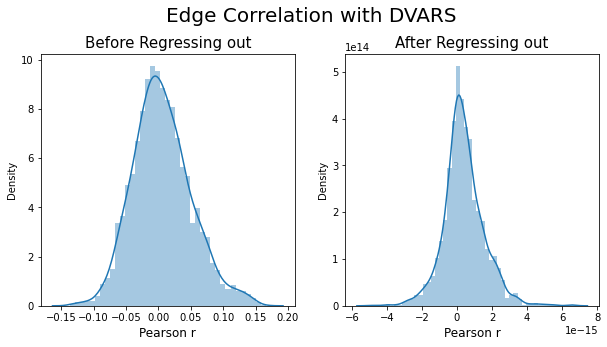

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.distplot([np.corrcoef(Y_asd_combat[:,ii], motion[np.squeeze(X)==1, 1])[0,1] \
              for ii in range(n_links)], ax = axs[0])
axs[0].set_title("Before Regressing out", size=15)
axs[0].set_xlabel("Pearson r", size=12)

sns.distplot([np.corrcoef(Y_asd_combat_denoised[:,ii], motion[np.squeeze(X)==1,1])[0,1] \
              for ii in range(n_links)], ax = axs[1])
axs[1].set_title("After Regressing out", size=15)
axs[1].set_xlabel("Pearson r", size=12)
plt.suptitle("Edge Correlation with DVARS", size=20)
fig.subplots_adjust(top=0.85, bottom=0.15)
pass

/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/javi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


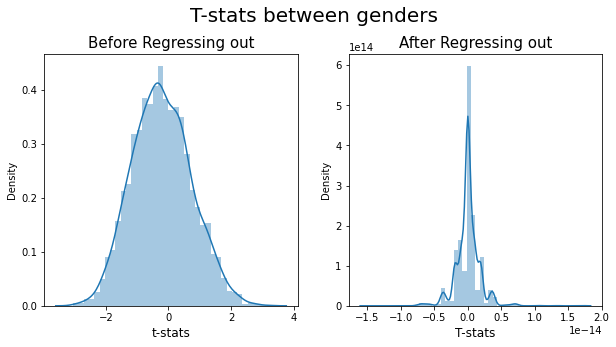

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.distplot([ttest_ind(Y_asd_combat[sex[np.squeeze(X)==1]==1,ii], 
                        Y_asd_combat[sex[np.squeeze(X)==1]==2,ii])[0] for ii in range(n_links)], ax = axs[0])
axs[0].set_title("Before Regressing out", size=15)
axs[0].set_xlabel("t-stats", size=12)

sns.distplot([ttest_ind(Y_asd_combat_denoised[sex[np.squeeze(X)==1]==1,ii], 
                        Y_asd_combat_denoised[sex[np.squeeze(X)==1]==2,ii])[0] for ii in range(n_links)], ax = axs[1])
axs[1].set_title("After Regressing out", size=15)
axs[1].set_xlabel("T-stats", size=12)

plt.suptitle("T-stats between genders", size=20)
fig.subplots_adjust(top=0.85, bottom=0.15)
pass

Build square matrices again from the upper triangular parts

In [17]:
CC_combat_asd_denoised = np.array([squareform(Y_asd_combat_denoised[ii, :]) + np.identity(n_rois) \
                                   for ii in range(n_asd)])

Save everything to disk for later use

In [21]:
np.savez(opj(data_dir,'data_after_combat_82regs_motion_aggressive_My21.npz'), 
         subjects=subjects,
         age = age, 
         sex=sex, 
         site=site, 
         group=group, 
         Y_combat = Y_combat,
         CC_combat = np.array([squareform(y) + np.eye(n_rois) for y in Y_combat]),
         motion = motion,
         CC_combat_asd_denoised = CC_combat_asd_denoised)

# Save connectivity matrices alone for clustering
savemat(opj(data_dir,'cors_combat_both_82regs_motion_aggressive_My21.mat'), 
        {'CC_combat_asd_denoised': CC_combat_asd_denoised})